In [63]:
from tensorflow.keras.models import Sequential
#import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras_tuner.tuners import RandomSearch

In [64]:
img_height=224
img_width=224
batch_size=32
data_dir = '../data/dog_v1'

In [65]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1030 files belonging to 5 classes.
Using 824 files for training.


In [66]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1030 files belonging to 5 classes.
Using 206 files for validation.


In [67]:
class_names = train_ds.class_names
print(class_names)

['french_bulldog', 'german_shepherd', 'golden_retriever', 'poodle', 'yorkshire_terrier']


2024-04-17 14:56:48.932423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


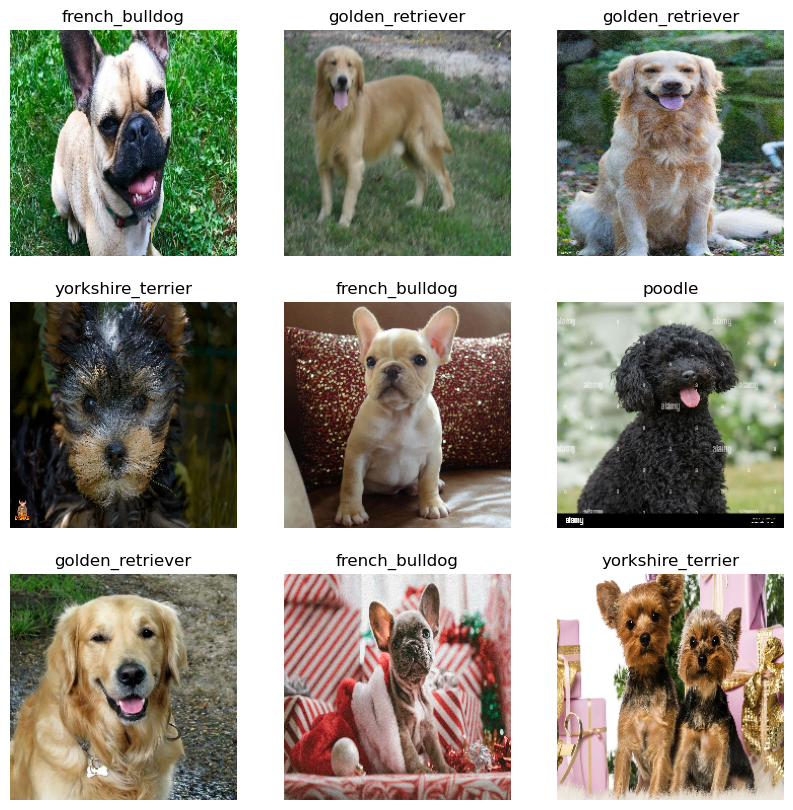

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [69]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [70]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [71]:
normalization_layer = layers.Rescaling(1./255)

train_ds_norm = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds_norm = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds_norm))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [72]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomZoom(0.5),
  ]
)

/opt/conda/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2024-04-17 14:57:02.661540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


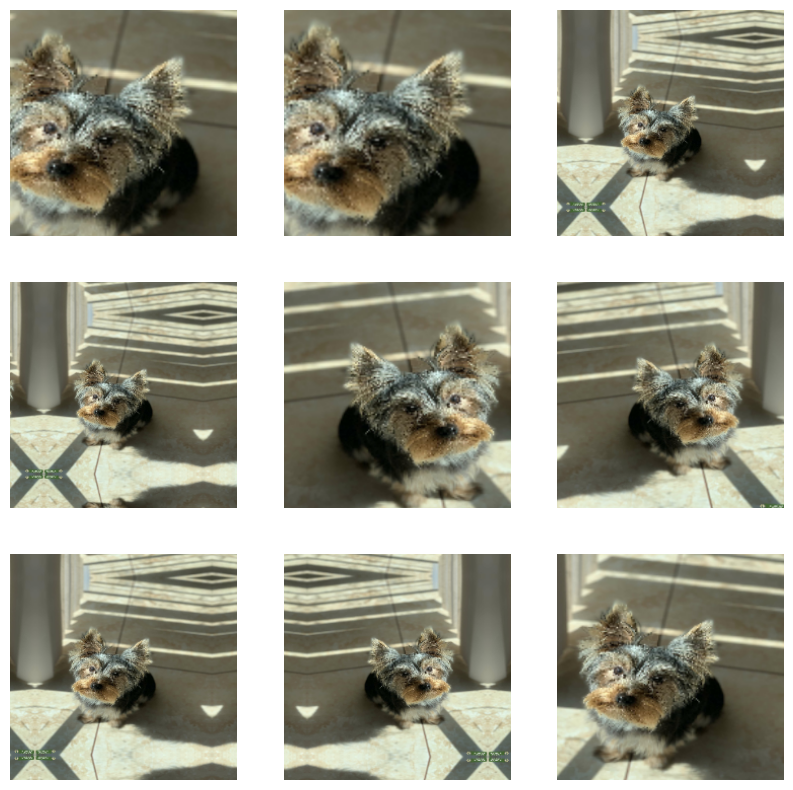

In [73]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [74]:
hyperparameters = {
    'l2_reg': [.1,.01,.001],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [1e-3, 5e-4, 1e-4]
}

In [75]:
def build_model(hp):
    model = Sequential([
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', values=hyperparameters['l2_reg']))),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', values=hyperparameters['l2_reg']))),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', values=hyperparameters['l2_reg']))),
        layers.MaxPooling2D(),
        layers.Dropout(hp.Choice('dropout_rate', values=hyperparameters['dropout_rate'])),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(5)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=hyperparameters['learning_rate'])),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

In [76]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    project_name='animal_classificaion'
)

In [78]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(train_ds, validation_data=val_ds, epochs=10)
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 491ms/step - accuracy: 0.2379 - loss: 1.7420 - val_accuracy: 0.3447 - val_loss: 1.6431
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 480ms/step - accuracy: 0.3049 - loss: 1.6395 - val_accuracy: 0.2670 - val_loss: 1.6254
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 481ms/step - accuracy: 0.2527 - loss: 1.6326 - val_accuracy: 0.3010 - val_loss: 1.5846
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.3555 - loss: 1.5309 - val_accuracy: 0.3592 - val_loss: 1.5239
Epoch 5/10
20/26 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.4479 - loss: 1.4463

KeyboardInterrupt: 

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor="loss", factor=0.1, patience=5, mode="max", verbose=1
)

# Early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

save_callback=keras.callbacks.ModelCheckpoint(
    'best_model.keras', monitor="val_acc",save_best_only=True,mode='max',verbose=1
)

In [ ]:
best_model=build_model(best_hps)
history=best_model.fit(train_ds,epochs=10,batch_size=batch_size,validation_data=val_ds,verbose=2)

Epoch 1/10


26/26 - 16s - 613ms/step - accuracy: 0.2063 - loss: 1.6159 - val_accuracy: 0.2573 - val_loss: 1.6130
Epoch 2/10
26/26 - 14s - 542ms/step - accuracy: 0.2354 - loss: 1.6130 - val_accuracy: 0.2573 - val_loss: 1.6034
Epoch 3/10
26/26 - 20s - 771ms/step - accuracy: 0.2354 - loss: 1.6114 - val_accuracy: 0.2573 - val_loss: 1.6028
Epoch 4/10
26/26 - 14s - 526ms/step - accuracy: 0.2354 - loss: 1.6107 - val_accuracy: 0.2573 - val_loss: 1.6012
Epoch 5/10
26/26 - 14s - 524ms/step - accuracy: 0.2354 - loss: 1.6109 - val_accuracy: 0.2573 - val_loss: 1.6013
Epoch 6/10
26/26 - 14s - 525ms/step - accuracy: 0.2354 - loss: 1.6103 - val_accuracy: 0.2573 - val_loss: 1.6026
Epoch 7/10
26/26 - 14s - 523ms/step - accuracy: 0.2354 - loss: 1.6093 - val_accuracy: 0.2573 - val_loss: 1.5989
Epoch 8/10
26/26 - 14s - 527ms/step - accuracy: 0.2354 - loss: 1.6094 - val_accuracy: 0.2573 - val_loss: 1.5973
Epoch 9/10
26/26 - 14s - 534ms/step - accuracy: 0.2354 - loss: 1.6082 - val_accuracy: 0.2573 - val_loss: 1.5999
Epo

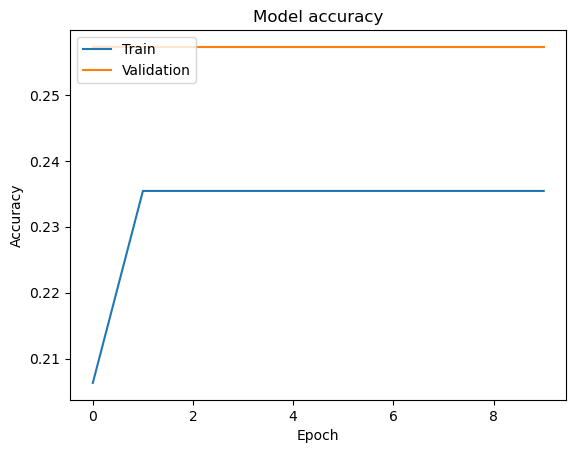

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_url = "https://i.pinimg.com/originals/10/d7/75/10d775b05c5c4251f1ea02dab4cda35c.jpg"
test_path = tf.keras.utils.get_file('golden_retriever', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = best_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
This image most likely belongs to german_shepherd with a 98.87 percent confidence.
